## Income Risks Estimation 

This noteobok contains the following

 - Estimation functions of time-varying income risks for an integrated moving average(IMA) process of income/earnings
 - It uses the function to estimate the realized risks using PSID data 

In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
#from scipy.optimize import minimize
import pandas as pd
import copy as cp

In [2]:
from IncomeProcess import IMAProcess as ima

In [3]:
## debugging test of the data 

t = 100
ma_nosa = np.array([1])  ## ma coefficient without serial correlation
p_sigmas = np.arange(t)  # sizes of the time-varying permanent volatility 
p_sigmas_rw = np.ones(t) # a special case of time-invariant permanent volatility, random walk 
p_sigmas_draw = np.random.uniform(0,1,t) ## allowing for time-variant shocks 

pt_ratio = 0.33
t_sigmas = pt_ratio * p_sigmas_draw # sizes of the time-varyingpermanent volatility
sigmas = np.array([p_sigmas_draw,
                   t_sigmas])

dt = ima(t = t,
         ma_coeffs = ma_nosa)
dt.sigmas = sigmas
sim_data = dt.SimulateSeries(n_sim = 2000)
sim_moms = dt.SimulatedMoments()

In [4]:
## get the computed moments 

comp_moms = dt.ComputeGenMoments()

av_comp = comp_moms['Mean']
cov_var_comp = comp_moms['Var']
var_comp = dt.AutocovarComp(step=0) #np.diagonal(cov_var_comp)
autovarb1_comp = dt.AutocovarComp(step=-1)  #np.array([cov_var_comp[i,i+1] for i in range(len(cov_var_comp)-1)]) 

In [5]:
## get the simulated moments 
av = sim_moms['Mean']
cov_var = sim_moms['Var']
var = dt.Autocovar(step = 0)   #= np.diagonal(cov_var)
autovarb1 = dt.Autocovar(step = -1) #np.array([cov_var[i,i+1] for i in range(len(cov_var)-1)]) 

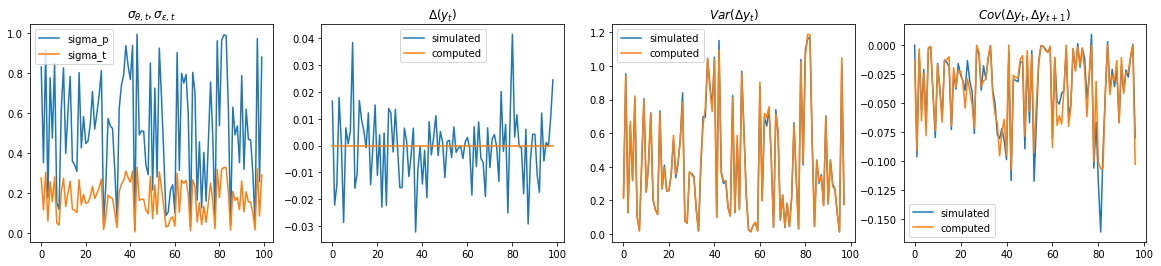

In [6]:
## plot simulated moments of first diff 

plt.figure(figsize=((20,4)))

plt.subplot(1,4,1)
plt.title(r'$\sigma_{\theta,t},\sigma_{\epsilon,t}$')
plt.plot(p_sigmas_draw,label='sigma_p')
plt.plot(t_sigmas,label='sigma_t')
plt.legend(loc=0)

plt.subplot(1,4,2)
plt.title(r'$\Delta(y_t)$')
plt.plot(av,label='simulated')
plt.plot(av_comp,label='computed')
plt.legend(loc=0)

plt.subplot(1,4,3)
plt.title(r'$Var(\Delta y_t)$')
plt.plot(var,label='simulated')
plt.plot(var_comp,label='computed')
plt.legend(loc=0)

plt.subplot(1,4,4)
plt.title(r'$Cov(\Delta y_t,\Delta y_{t+1})$')
plt.plot(autovarb1,label='simulated')
plt.plot(autovarb1_comp,label='computed')
plt.legend(loc = 0)

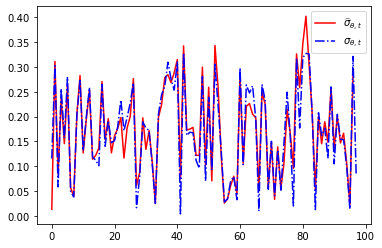

In [7]:
## robustness check if the transitory risks is approximately equal to the assigned level

sigma_t_est = np.array(np.sqrt(abs(autovarb1)))
plt.plot(sigma_t_est,'r-',label=r'$\widehat \sigma_{\theta,t}$')
plt.plot(t_sigmas[1:-1],'b-.',label=r'$\sigma_{\theta,t}$')  # the head and tail trimmed
plt.legend(loc=1)

### Estimation

In [8]:
## some fake data moments with alternative parameters

## fix ratio of p and t risks
pt_ratio_fake = 0.66
t_sigmas = pt_ratio_fake * p_sigmas_draw # sizes of the time-varyingpermanent volatility

## both p and t risks are draws
p_sigmas_draw = np.random.uniform(0,1,t)
t_sigmas_draw = np.random.uniform(0,1,t)

sigmas = np.array([p_sigmas_draw,
                   t_sigmas_draw])

dt_fake = ima(t = t,
              ma_coeffs = ma_nosa)
dt_fake.sigmas = sigmas
data_fake = dt_fake.SimulateSeries(n_sim = 5000)
moms_fake = dt_fake.SimulatedMoments()

### Estimation using fake data

In [9]:
## estimation of income risks 

dt_est = cp.deepcopy(dt)
dt_est.GetDataMoments(moms_fake)

para_guess_this = np.ones(2*t  + dt_est.ma_q)  # make sure the length of the parameters are right 

In [10]:
para_est = dt_est.EstimatePara(method='BFGS',
                               para_guess = para_guess_this)

Optimization terminated successfully.
         Current function value: 1.431201
         Iterations: 136
         Function evaluations: 28078
         Gradient evaluations: 139


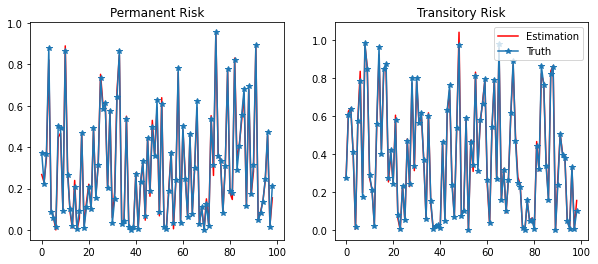

In [11]:
## check the estimation and true parameters 

fig = plt.figure(figsize=([10,4]))

plt.subplot(1,2,1)
plt.title('Permanent Risk')
plt.plot(dt_est.para_est[1][0][1:].T**2,'r-',label='Estimation')
plt.plot(dt_fake.sigmas[0][1:]**2,'-*',label='Truth')

plt.subplot(1,2,2)
plt.title('Transitory Risk')
plt.plot(dt_est.para_est[1][1][1:].T**2,'r-',label='Estimation')
plt.plot(dt_fake.sigmas[1][1:]**2,'-*',label='Truth')
plt.legend(loc=0)

### Estimation using PSID data



In [413]:
## PSID data 
PSID = pd.read_stata('../../../PSID/J276289/psid_matrix.dta',
                    convert_categoricals=False)   
PSID.index = PSID['uniqueid']
PSID = PSID.drop(['uniqueid'], axis=1)
PSID = PSID.dropna(axis=0,how='all')
PSID = PSID.dropna(axis=1,how='all')

#PSID = PSID.rename(columns={'edu_i_g':'edu_i_g', ##
#                           'sex_h':'sex_h',   # 1 male 2 female 
#                           'byear_5yr':'byear_5yr'})

#PSID=PSID.dropna(subset=['byear_5yr'])

#PSID['byear_5yr'] = PSID['byear_5yr'].astype('int32')


In [414]:
PSID.dtypes

sex_h                  float64
edu_i_g                float32
age_5yr                float32
lwage_id_shk_gr1972    float32
lwage_id_shk_gr1973    float32
lwage_id_shk_gr1974    float32
lwage_id_shk_gr1975    float32
lwage_id_shk_gr1976    float32
lwage_id_shk_gr1977    float32
lwage_id_shk_gr1978    float32
lwage_id_shk_gr1979    float32
lwage_id_shk_gr1980    float32
lwage_id_shk_gr1981    float32
lwage_id_shk_gr1982    float32
lwage_id_shk_gr1983    float32
lwage_id_shk_gr1984    float32
lwage_id_shk_gr1985    float32
lwage_id_shk_gr1986    float32
lwage_id_shk_gr1987    float32
lwage_id_shk_gr1988    float32
lwage_id_shk_gr1989    float32
lwage_id_shk_gr1990    float32
lwage_id_shk_gr1991    float32
lwage_id_shk_gr1992    float32
lwage_id_shk_gr1993    float32
lwage_id_shk_gr1994    float32
lwage_id_shk_gr1995    float32
lwage_id_shk_gr1996    float32
lwage_id_shk_gr1997    float32
lwage_id_shk_gr1999    float32
lwage_id_shk_gr2001    float32
lwage_id_shk_gr2003    float32
lwage_id

In [416]:
## different samples 

education_groups = [1, #'HS dropout',
                   2, # 'HS graduate',
                   3] #'college graduates/above'
gender_groups = [1, #'male',
                2] #'male'

#byear_groups = list(np.array(PSID.byear_5yr.unique(),dtype='int32'))

age_groups = list(np.array(PSID.age_5yr.unique(),dtype='int32'))


group_by = ['edu_i_g','sex_h','age_5yr']
all_drop = group_by #+['age_h','byear_5yr']

## full sample 
sample_full =  PSID.drop(all_drop,axis=1)


## sub sample 
sub_samples = []
para_est_list = []
sub_group_names = []

for edu in education_groups:
    for gender in gender_groups:
        for age5 in age_groups:
            belong = (PSID['edu_i_g']==edu) & (PSID['sex_h']==gender) & (PSID['age_5yr']==age5)
            obs = np.sum(belong)
            #print(obs)
            if obs > 1:
                sample = PSID.loc[belong].drop(all_drop,axis=1)
                sub_samples.append(sample)
                sub_group_names.append((edu,gender,age5))

In [417]:
## estimation for full sample 

data_para_est_full = estimate_sample(sample_full)

Optimization terminated successfully.
         Current function value: 2.800409
         Iterations: 99
         Function evaluations: 10032
         Gradient evaluations: 132


In [422]:
## estimation for sub-group

for sample in sub_samples:
    ## estimation
    data_para_est = estimate_sample(sample)
    para_est_list.append(data_para_est)

Optimization terminated successfully.
         Current function value: 5.453458
         Iterations: 101
         Function evaluations: 15352
         Gradient evaluations: 202
Optimization terminated successfully.
         Current function value: 1.312674
         Iterations: 166
         Function evaluations: 17784
         Gradient evaluations: 234
Optimization terminated successfully.
         Current function value: 7.122622
         Iterations: 126
         Function evaluations: 17100
         Gradient evaluations: 225
Optimization terminated successfully.
         Current function value: 7.534651
         Iterations: 143
         Function evaluations: 18316
         Gradient evaluations: 241


/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


Optimization terminated successfully.
         Current function value: 6.554078
         Iterations: 470
         Function evaluations: 56012
         Gradient evaluations: 737
Optimization terminated successfully.
         Current function value: 2.081016
         Iterations: 98
         Function evaluations: 13832
         Gradient evaluations: 182
Optimization terminated successfully.
         Current function value: 2.867848
         Iterations: 234
         Function evaluations: 28652
         Gradient evaluations: 377
Optimization terminated successfully.
         Current function value: 2.028582
         Iterations: 125
         Function evaluations: 12996
         Gradient evaluations: 171
Optimization terminated successfully.
         Current function value: 6.146604
         Iterations: 236
         Function evaluations: 24548
         Gradient evaluations: 323
Optimization terminated successfully.
         Current function value: 25.155137
         Iterations: 277
         F

In [423]:
## time stamp 
t0 = 1971
tT = 2016
t_break = 1998 #the year when no annual data was released i.e. no 1998 data 
years = np.arange(t0+1,tT+2)
years=years.astype(int)

years_sub = np.concatenate((np.arange(t0+1,t_break),np.arange(t_break+1,tT+2,2)))

In [424]:
years_sub

array([1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1999, 2001, 2003, 2005, 2007, 2009, 2011,
       2013, 2015, 2017])

In [425]:
years

array([1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017])

whole sample


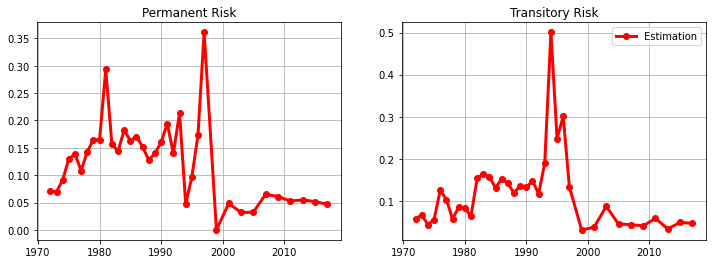

In [426]:
## plot estimate 

lw = 3
for i,paras_est in enumerate([data_para_est_full]):
    print('whole sample')
    fig = plt.figure(figsize=([12,4]))
    this_est = paras_est
    plt.subplot(1,2,1)
    plt.title('Permanent Risk')
    plt.plot(years_sub,
             this_est[1][0][1:].T**2,
             'r-o',
             lw=lw,
             label='Estimation')
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.title('Transitory Risk')
    plt.plot(years_sub,
             this_est[1][1][1:].T**2,
             'r-o',
             lw=lw,
             label='Estimation')
    plt.legend(loc=0)
    plt.grid(True)

In [427]:
## generate a dataset of year, edu, gender, byear_5yr permanent and transitory 

est_df = pd.DataFrame()

#vols_est_sub_group = pd.DataFrame([])
for i,para_est in enumerate(para_est_list):
    #print(i)
    group_var = sub_group_names[i]
    #print(group_var)
    times = len(years_sub)
    this_est = pd.DataFrame([[group_var[0]]*times,   ##educ
                             [group_var[1]]*times,   ## gender 
                             [group_var[2]]*times,   ## 
                             list(years_sub),
                             para_est[1][0],
                             para_est[1][1]]).transpose()
    est_df = est_df.append(this_est)

In [428]:
## post processing
est_df.columns = grouping_by+['year','permanent','transitory']
est_df=est_df.dropna(how='any')
for var in grouping_by+['year']:
    est_df[var] = est_df[var].astype('int32')

In [429]:
est_df.to_stata('../OtherData/psid/psid_history_vol_decomposed_edu_gender_age5.dta')

### Experienced volatility specific to cohort 

In [22]:
## full sample 
history_vols_whole = pd.DataFrame([list(years_sub),para_est_full[1][0],para_est_full[1][1]]).transpose()


## sub group 
history_vols_hsd = pd.DataFrame([list(years_sub),para_est_list[0][1][0],para_est_list[0][1][1]]).transpose()
history_vols_hsg = pd.DataFrame([list(years_sub),para_est_list[1][1][0],para_est_list[1][1][1]]).transpose()
history_vols_cg = pd.DataFrame([list(years_sub),para_est_list[2][1][0],para_est_list[2][1][1]]).transpose()

for dt in [history_vols_whole,
          history_vols_hsd,
          history_vols_hsg,
          history_vols_cg]:
    dt.columns = ['year','permanent','transitory']

In [23]:
## whole data 
dataset_psid = pd.read_excel('../OtherData/psid/psid_history_vol.xls')
## education data
dataset_psid_edu = pd.read_excel('../OtherData/psid/psid_history_vol_edu.xls')

In [24]:
## for whole sample
names = ['whole'] ## whole sample/ high school dropout / high school graduate / college graduate above
for sample_id,sample in enumerate([history_vols_whole]):
    # prepare data 
    history_vols = dataset_psid
    history_vols['permanent'] = np.nan
    history_vols['transitory'] = np.nan
    
    
    for i in history_vols.index:
        #print(i)
        year = history_vols['year'].iloc[i]
        #print(year)
        born = history_vols['cohort'].iloc[i]-20
        #print(born)
        av_per_vol = np.mean(sample['permanent'].loc[(sample['year']>born) & 
                                                                (sample['year']<=year)] )
        #print(av_per_vol)
        av_tran_vol = np.mean(sample['transitory'].loc[(sample['year']>born) & 
                                                                (sample['year']<=year)])
        #print(av_tran_vol)
        history_vols['permanent'].iloc[i] = av_per_vol
        history_vols['transitory'].iloc[i] = av_tran_vol
        
    ## save to excel for further analysis 
    history_vols.to_excel('../OtherData/psid/psid_history_vol_decomposed_'+str(names[sample_id])+'.xlsx')

/Users/Myworld/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [ ]:
## for sub-education group 

# prepare data 
history_vols = dataset_psid_edu
history_vols['permanent'] = np.nan
history_vols['transitory'] = np.nan

samples = [history_vols_hsd,
           history_vols_hsg,
           history_vols_cg]
        

for i in history_vols.index:
    #print(i)
    year = history_vols['year'].iloc[i]
    #print(year)
    born = history_vols['cohort'].iloc[i]-20
    #print(born)
    edu = history_vols['edu'].iloc[i]
    #print(edu)
    
    sample = samples[edu-1] ## 1 hsd, 2 hsg, 3 cg 
    
    av_per_vol = np.mean(sample['permanent'].loc[(sample['year']>born) &
                                                 (sample['year']<=year)] )
    #print(av_per_vol)
    av_tran_vol = np.mean(sample['transitory'].loc[(sample['year']>born) &
                                                   (sample['year']<=year)])
    #print(av_tran_vol)
    history_vols['permanent'].iloc[i] = av_per_vol
    history_vols['transitory'].iloc[i] = av_tran_vol
        
## save to excel for further analysis 
history_vols.to_excel('../OtherData/psid/psid_history_vol_decomposed_edu.xlsx')

### Estimation using simulated moments 

In [16]:
"""
para_guess_this2 = para_guess_this*0.3

bounds_this = ((0,1),) + ((0,0.5),)*(2*t)

para_est_sim = dt_est.EstimateParabySim(method='TNC',
                                        para_guess = para_guess_this2,
                                        options={'disp':True}
                                       )
                                       
"""

In [155]:
"""
## check the estimation and true parameters

fig = plt.figure(figsize=([10,4]))

plt.subplot(1,2,1)
plt.title('Permanent Risk')
plt.plot(dt_est.para_est_sim[1][0][1:].T**2,'r-',label='Estimation(sim)')
plt.plot(dt_fake.sigmas[0][1:]**2,'-*',label='Truth')


plt.subplot(1,2,2)
plt.title('Transitory Risk')
plt.plot(dt_est.para_est_sim[1][1][1:].T**2,'r-',label='Estimation(sim)')
plt.plot(dt_fake.sigmas[1][1:]**2,'-*',label='Truth')
plt.legend(loc=0)

"""

"\n## check the estimation and true parameters\n\nfig = plt.figure(figsize=([10,4]))\n\nplt.subplot(1,2,1)\nplt.title('Permanent Risk')\nplt.plot(dt_est.para_est_sim[1][0][1:].T**2,'r-',label='Estimation(sim)')\nplt.plot(dt_fake.sigmas[0][1:]**2,'-*',label='Truth')\n\n\nplt.subplot(1,2,2)\nplt.title('Transitory Risk')\nplt.plot(dt_est.para_est_sim[1][1][1:].T**2,'r-',label='Estimation(sim)')\nplt.plot(dt_fake.sigmas[1][1:]**2,'-*',label='Truth')\nplt.legend(loc=0)\n\n"

In [34]:
### reapeating the estimation for many times

"""
n_loop = 5

para_est_sum_sim = (np.array([0]),np.zeros([2,50]))
for i in range(n_loop):
    para_est_this_time = dt_est.EstimateParabySim(method='CG',
                                                  para_guess = para_guess_this2,
                                                  options = {'disp': True})
    para_est_sum_sim  = para_est_sum_sim + para_est_this_time
    
    
"""

"\nn_loop = 5\n\npara_est_sum_sim = (np.array([0]),np.zeros([2,50]))\nfor i in range(n_loop):\n    para_est_this_time = dt_est.EstimateParabySim(method='CG',\n                                                  para_guess = para_guess_this2,\n                                                  options = {'disp': True})\n    para_est_sum_sim  = para_est_sum_sim + para_est_this_time\n    \n    \n"

In [31]:
#para_est_av = sum([abs(para_est_sum_sim[2*i+1]) for i in range(1,n_loop+1)] )/n_loop

In [35]:
## check the estimation and true parameters

"""
fig = plt.figure(figsize=([14,4]))

plt.subplot(1,2,1)
plt.title('Permanent Risk')
plt.plot(para_est_av[0][1:].T**2,'r-',label='Estimation(sim)')
plt.plot(dt_fake.sigmas[0][1:]**2,'-*',label='Truth')


plt.subplot(1,2,2)
plt.title('Transitory Risk')
plt.plot(para_est_av[1][1:].T**2,'r-',label='Estimation(sim)')
plt.plot(dt_fake.sigmas[1][1:]**2,'-*',label='Truth')
plt.legend(loc=0)

"""

"\nfig = plt.figure(figsize=([14,4]))\n\nplt.subplot(1,2,1)\nplt.title('Permanent Risk')\nplt.plot(para_est_av[0][1:].T**2,'r-',label='Estimation(sim)')\nplt.plot(dt_fake.sigmas[0][1:]**2,'-*',label='Truth')\n\n\nplt.subplot(1,2,2)\nplt.title('Transitory Risk')\nplt.plot(para_est_av[1][1:].T**2,'r-',label='Estimation(sim)')\nplt.plot(dt_fake.sigmas[1][1:]**2,'-*',label='Truth')\nplt.legend(loc=0)\n\n"

### Time Aggregation

In [ ]:
## time aggregation 

sim_data = dt.SimulateSeries(n_sim = 1000)
dt.n_agg = 3
agg_series = dt.TimeAggregate()
agg_series_moms = dt.SimulateMomentsAgg()

In [ ]:
## difference times degree of time aggregation leads to different autocorrelation

for ns in np.array([2,8]):
    an_instance = cp.deepcopy(dt)
    an_instance.n_agg = ns
    series = an_instance.SimulateSeries(n_sim =500)
    agg_series = an_instance.TimeAggregate()
    agg_series_moms = an_instance.SimulateMomentsAgg()
    var_sim = an_instance.AutocovarAgg(step=0)
    var_b1 = an_instance.AutocovarAgg(step=-1)
    plt.plot(var_b1,label=r'={}'.format(ns))
plt.legend(loc=1)
plt.title('1-degree autocovariance of different \n level of time aggregation')


#### Estimation using time aggregated data

In [36]:
## get some fake aggregated data moments
"""
moms_agg_fake = dt_fake.TimeAggregate()
moms_agg_dct_fake = dt_fake.SimulateMomentsAgg()
"""

'\nmoms_agg_fake = dt_fake.TimeAggregate()\nmoms_agg_dct_fake = dt_fake.SimulateMomentsAgg()\n'

In [37]:
## estimation 
"""
para_guess_this3 = para_guess_this*0.5
dt_est.GetDataMomentsAgg(moms_agg_dct_fake)
dt_est.n_periods = 12
para_est_agg = dt_est.EstimateParaAgg(method ='Powell',
                                      para_guess = para_guess_this3,
                                      options={'disp':True,
                                              'ftol': 0.000000001}
                                     )
                                     
"""

"\npara_guess_this3 = para_guess_this*0.5\ndt_est.GetDataMomentsAgg(moms_agg_dct_fake)\ndt_est.n_periods = 12\npara_est_agg = dt_est.EstimateParaAgg(method ='Powell',\n                                      para_guess = para_guess_this3,\n                                      options={'disp':True,\n                                              'ftol': 0.000000001}\n                                     )\n                                     \n"

In [38]:
## check the estimation and true parameters

"""
fig = plt.figure(figsize=([10,4]))

plt.subplot(1,2,1)
plt.title('Permanent Risk')
plt.plot(dt_est.para_est_agg[1][0][11:-1].T**2,'r-',label='Estimation(agg)')
plt.plot(dt_fake.sigmas[0][11:-1]**2,'-*',label='Truth')

plt.subplot(1,2,2)
plt.title('Transitory Risk')
plt.plot(dt_est.para_est_agg[1][1][11:-1].T**2,'r-',label='Estimation(agg)')
plt.plot(dt_fake.sigmas[1][11:-1]**2,'-*',label='Truth')
plt.legend(loc=0)

"""

"\nfig = plt.figure(figsize=([10,4]))\n\nplt.subplot(1,2,1)\nplt.title('Permanent Risk')\nplt.plot(dt_est.para_est_agg[1][0][11:-1].T**2,'r-',label='Estimation(agg)')\nplt.plot(dt_fake.sigmas[0][11:-1]**2,'-*',label='Truth')\n\nplt.subplot(1,2,2)\nplt.title('Transitory Risk')\nplt.plot(dt_est.para_est_agg[1][1][11:-1].T**2,'r-',label='Estimation(agg)')\nplt.plot(dt_fake.sigmas[1][11:-1]**2,'-*',label='Truth')\nplt.legend(loc=0)\n\n"

In [39]:
### reapeating the estimation for many times

"""
n_loop = 5

para_est_sum_agg = (np.array([0]),np.zeros([2,50]))
for i in range(n_loop):
    para_est_this_time = dt_est.EstimateParaAgg(method ='Powell',
                                      para_guess = para_guess_this3,
                                      options={'disp':True,
                                              'ftol': 0.000000001})
    para_est_sum_agg = para_est_sum_agg + para_est_this_time
    
"""

"\nn_loop = 5\n\npara_est_sum_agg = (np.array([0]),np.zeros([2,50]))\nfor i in range(n_loop):\n    para_est_this_time = dt_est.EstimateParaAgg(method ='Powell',\n                                      para_guess = para_guess_this3,\n                                      options={'disp':True,\n                                              'ftol': 0.000000001})\n    para_est_sum_agg = para_est_sum_agg + para_est_this_time\n    \n"

In [40]:
para_est_av_agg = sum([abs(para_est_sum_agg[2*i+1]) for i in range(1,n_loop+1)] )/n_loop

NameError: name 'n_loop' is not defined

In [41]:
## check the estimation and true parameters


"""
fig = plt.figure(figsize=([14,4]))


plt.subplot(1,2,1)
plt.title('Permanent Risk')
plt.plot(para_est_av_agg[0][11:].T**2,'r-',label='Estimation(agg)')
plt.plot(dt_fake.sigmas[0][11:]**2,'-*',label='Truth')

plt.subplot(1,2,2)
plt.title('Transitory Risk')
plt.plot(para_est_av_agg[1][11:].T**2,'r-',label='Estimation(agg)')
plt.plot(dt_fake.sigmas[1][11:]**2,'-*',label='Truth')
plt.legend(loc=0)

"""

"\nfig = plt.figure(figsize=([14,4]))\n\n\nplt.subplot(1,2,1)\nplt.title('Permanent Risk')\nplt.plot(para_est_av_agg[0][11:].T**2,'r-',label='Estimation(agg)')\nplt.plot(dt_fake.sigmas[0][11:]**2,'-*',label='Truth')\n\nplt.subplot(1,2,2)\nplt.title('Transitory Risk')\nplt.plot(para_est_av_agg[1][11:].T**2,'r-',label='Estimation(agg)')\nplt.plot(dt_fake.sigmas[1][11:]**2,'-*',label='Truth')\nplt.legend(loc=0)\n\n"